Inicio del programa

Scraping pagina Web Colombia TIC

In [56]:
import os
import re
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

# Configuración de Selenium
service = Service('C:/Users/Josvaldes/Documents/Maestria/Austral/trabajoGrado/Codigo/chromedriver.exe')
driver = webdriver.Chrome(service=service)

# URL de la página principal
url = 'https://colombiatic.mintic.gov.co/679/w3-channel.html'
driver.get(url)

# Función para verificar si el archivo del trimestre ya existe
def archivo_trimestral_existente(nombre_archivo):
    # Verificar en el directorio actual si existe un archivo con el nombre especificado
    return os.path.exists(nombre_archivo)

try:
    # Esperar y encontrar la sección "Destacados"
    destacados_header = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.XPATH, "//h2[@class='ntg-titulo-caja' and text()='Destacados']"))
    )
    print("Se encontró la sección 'Destacados'.")

    # Buscar el enlace al artículo en la sección "Destacados"
    destacados_section = driver.find_element(By.XPATH, "//div[@class='recuadro col-md-6 col-lg-4 text-center mb-4']")
    link_element = destacados_section.find_element(By.TAG_NAME, "a")
    report_url = link_element.get_attribute('href')

    print("URL del artículo:", report_url)

    # Extraer el trimestre y año del reporte a partir del texto del enlace (si está disponible)
    # Ejemplo: "Boletín trimestral del sector TIC - Cifras primer trimestre de 2024"
    trimestre_texto = link_element.text
    trimestre = re.search(r"(primer|segundo|tercer|cuarto) trimestre de (\d{4})", trimestre_texto, re.IGNORECASE)
    if trimestre:
        trimestre_nombre = trimestre.group(1)
        año = trimestre.group(2)
        nombre_archivo = f"reporte_tic_{trimestre_nombre}_trimestre_{año}.xlsx"
        print(f"Nombre esperado del archivo: {nombre_archivo}")
    else:
        print("No se pudo determinar el trimestre del reporte.")
        nombre_archivo = "reporte_tic_trimestral.xlsx"  # Nombre genérico si no se encuentra el trimestre

    # Verificar si el archivo del trimestre ya existe
    if archivo_trimestral_existente(nombre_archivo):
        print(f"El archivo '{nombre_archivo}' ya existe. No se realizará la descarga.")
    else:
        # Navegar a la página del artículo
        driver.get(report_url)

        # Esperar a que el `<span>` que contiene el enlace al archivo Excel esté presente
        excel_span = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//span[contains(@class, 'bajardoc') and contains(@class, 'binary-archivo_xls') and contains(@class, 'format-xlsx')]"))
        )

        # Obtener el enlace al archivo Excel
        excel_link = excel_span.find_element(By.TAG_NAME, "a")
        excel_url = excel_link.get_attribute('href')
        print("URL del archivo Excel:", excel_url)

        # Descargar el archivo Excel usando requests
        excel_response = requests.get(excel_url)

        # Verificar el código de estado antes de guardar
        if excel_response.status_code == 200:
            with open(nombre_archivo, 'wb') as file:
                file.write(excel_response.content)
            print(f"Reporte descargado exitosamente como {nombre_archivo}")
        else:
            print(f"Error al descargar el archivo. Código de estado: {excel_response.status_code}")

except Exception as e:
    print("No se encontró la sección 'Destacados' o hubo un error:", str(e))

finally:
    # Cerrar el navegador
    driver.quit()

Se encontró la sección 'Destacados'.
URL del artículo: https://colombiatic.mintic.gov.co/679/w3-article-397520.html
Nombre esperado del archivo: reporte_tic_segundo_trimestre_2024.xlsx
El archivo 'reporte_tic_segundo_trimestre_2024.xlsx' ya existe. No se realizará la descarga.


Procesamiento del reporte descargado

In [42]:
# Cargar los nombres de las hojas
patch = nombre_archivo
excel_file = pd.ExcelFile(patch)
print("Hojas disponibles en el archivo:", excel_file.sheet_names)

Hojas disponibles en el archivo: ['PORTADA', 'CONTENIDO', '1', '2', '3', '4,1', '4,2', '4,3', '4,4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']


In [44]:
# Ruta del archivo descargado
patch = nombre_archivo

# Crear un diccionario para almacenar las primeras filas de cada hoja como DataFrames
sheets_preview = {}

try:
    # Cargar todas las hojas
    all_sheets = pd.read_excel(patch, sheet_name=None)

    # Obtener una vista previa de las primeras filas de cada hoja
    for sheet_name, df in all_sheets.items():
        # Almacenar las primeras 10 filas de cada hoja para revisión
        sheets_preview[sheet_name] = df.head(10)

    # Crear un archivo Excel para almacenar la vista previa de las primeras filas de cada hoja
    with pd.ExcelWriter("hojas_vista_previa.xlsx") as writer:
        for sheet_name, preview_df in sheets_preview.items():
            preview_df.to_excel(writer, sheet_name=sheet_name, index=False)

    print("Archivo 'hojas_vista_previa.xlsx' creado con éxito, con una vista previa de las primeras filas de cada hoja.")

except Exception as e:
    print("Error al cargar y listar la vista previa de las hojas:", e)

Archivo 'hojas_vista_previa.xlsx' creado con éxito, con una vista previa de las primeras filas de cada hoja.


In [64]:
# Diccionario que define los nombres de columnas esperados en cada hoja
column_structure = {
    '1': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'No. ACCESOS FIJOS A INTERNET'],
    '2': ['AÑO', 'TRIMESTRE', 'CÓDIGO DANE', 'DEPARTAMENTO', 'No. ACCESOS FIJOS A INTERNET', 'POBLACIÓN DANE', 'PENETRACIÓN'],
    '3': ['AÑO', 'TRIMESTRE', 'CÓDIGO DANE', 'DEPARTAMENTO', 'CÓDIGO DANE', 'MUNICIPIO', 'No. ACCESOS FIJOS A INTERNET', 'POBLACIÓN DANE', 'PENETRACIÓN'],
    '4,1': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'CÓDIGO DANE', 'DEPARTAMENTO', 'CÓDIGO DANE', 'MUNICIPIO', 'SEGMENTO', 'TECNOLOGÍA', 'VELOCIDAD BAJADA', 'VELOCIDAD SUBIDA', 'No. ACCESOS FIJOS A INTERNET'],
    '4,2': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'CÓDIGO DANE', 'DEPARTAMENTO', 'CÓDIGO DANE', 'MUNICIPIO', 'SEGMENTO', 'TECNOLOGÍA', 'VELOCIDAD BAJADA', 'VELOCIDAD SUBIDA', 'No. ACCESOS FIJOS A INTERNET'],
    '4,3': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'CÓDIGO DANE', 'DEPARTAMENTO', 'CÓDIGO DANE', 'MUNICIPIO', 'SEGMENTO', 'TECNOLOGÍA', 'VELOCIDAD BAJADA', 'VELOCIDAD SUBIDA', 'No. ACCESOS FIJOS A INTERNET'],
    '4,4': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'CÓDIGO DANE', 'DEPARTAMENTO', 'CÓDIGO DANE', 'MUNICIPIO', 'SEGMENTO', 'TECNOLOGÍA', 'VELOCIDAD BAJADA', 'VELOCIDAD SUBIDA', 'No. ACCESOS FIJOS A INTERNET'],
    '5': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'INGRESOS (Pesos)'],
    '6': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'SEGMENTO', 'TERMINAL', 'TECNOLOGÍA', 'No. ABONADOS'],
    '7': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'SEGMENTO', 'TERMINAL', 'INGRESOS'],
    '8': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'SEGMENTO', 'TRÁFICO (MB)'],
    '9': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'SEGMENTO', 'TERMINAL', 'TECNOLOGÍA', 'No. SUSCRIPTORES'],
    '10': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'SEGMENTO', 'TERMINAL', 'INGRESOS'],
    '11': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'TRÁFICO (MB)'],
    '12': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'LÍNEAS EN SERVICIO', 'LÍNEAS PREPAGO', 'LÍNEAS POSPAGO', 'LÍNEAS ACTIVADAS', 'LÍNEAS RETIRADAS'],
    '13': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'PROVEEDOR DESTINO', 'TRÁFICO PREPAGO', 'TRÁFICO POSPAGO'],
    '14': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'CONSUMO PREPAGO', 'CONSUMO POSPAGO', 'INGRESOS OPERACIONALES'],
    '15': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'CÓDIGO DANE', 'DEPARTAMENTO', 'CÓDIGO DANE', 'MUNICIPIO', 'CABECERA MUNICIPAL', 'CÓDIGO DANE', 'CENTRO POBLADO', 'COBERTURA 2G', 'COBERTURA 3G', 'COBERTURA HSPA+', 'HSPA+DC', 'COBERTURA_4G', 'COBERTURA_LTE', 'COBERTURA_5G'],
    '16': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'CÓDIGO DANE DEPARTAMENTO', 'DEPARTAMENTO', 'CÓDIGO DANE MUNICIPIO', 'MUNICIPIO', 'SEGMENTO', 'LÍNEAS EN SERVICIO'],
    '17': ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'INGRESOS TRÁFICO LDIE', 'INGRESOS TRÁFICO LDIS', 'INGRESOS TELEFONIA FIJA']
}



In [79]:
# Función para renombrar columnas duplicadas con sufijos secuenciales
def rename_duplicates(columns):
    counts = {}
    new_columns = []
    for col in columns:
        if col in counts:
            counts[col] += 1
            new_columns.append(f"{col}_dup{counts[col]}")
        else:
            counts[col] = 0
            new_columns.append(col)
    return new_columns

# Procesar y limpiar cada hoja
for sheet_name, df in all_sheets.items():
    # Eliminar las filas innecesarias (encabezados adicionales o filas introductorias)
    expected_columns = column_structure[sheet_name]
    df.columns = df.columns.str.strip()  # Limpiar espacios en los nombres de columnas

    # Encontrar la primera fila válida
    valid_row = df[df.iloc[:, 0].astype(str).str.match(r'^\d{4}$')].index.min()
    if valid_row is not None:
        df = df.iloc[valid_row:].reset_index(drop=True)  # Limpiar filas superiores
        df.columns = expected_columns  # Renombrar las columnas con los nombres esperados

    # Renombrar columnas duplicadas con sufijos secuenciales
    df.columns = rename_duplicates(df.columns)

    all_sheets[sheet_name] = df

# Empezar con la primera hoja como base del `merge`
combined_df = all_sheets['1']

# Iterar sobre las hojas restantes para combinarlas
for sheet_name, df in all_sheets.items():
    if sheet_name != '1':  # Saltar la primera hoja ya que es la base
        common_columns = combined_df.columns.intersection(df.columns).tolist()  # Detectar columnas comunes
        if common_columns:
            combined_df = pd.merge(combined_df, df, on=common_columns, how='outer')  # Merge con columnas comunes
            print(f"Hoja '{sheet_name}' combinada con columnas comunes: {common_columns}")
        else:
            print(f"Advertencia: No se encontraron columnas comunes para combinar con la hoja '{sheet_name}'")

# Mostrar una muestra del DataFrame combinado final
print("DataFrame combinado final:")
print(combined_df.head())

# Guardar el DataFrame combinado en un archivo Excel para revisión
combined_df.to_excel("data_reporte_combined_final_v3.xlsx", index=False)
print("DataFrame combinado exportado a 'data_reporte_combined_final_v3.xlsx'.")

Hoja '2' combinada con columnas comunes: ['AÑO', 'TRIMESTRE', 'No. ACCESOS FIJOS A INTERNET']
Hoja '3' combinada con columnas comunes: ['AÑO', 'TRIMESTRE', 'No. ACCESOS FIJOS A INTERNET', 'CÓDIGO DANE', 'DEPARTAMENTO', 'POBLACIÓN DANE', 'PENETRACIÓN']
Hoja '4,1' combinada con columnas comunes: ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'No. ACCESOS FIJOS A INTERNET', 'CÓDIGO DANE', 'DEPARTAMENTO', 'CÓDIGO DANE_dup1', 'MUNICIPIO']
Hoja '5' combinada con columnas comunes: ['AÑO', 'TRIMESTRE', 'PROVEEDOR']
Hoja '6' combinada con columnas comunes: ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'SEGMENTO', 'TECNOLOGÍA']
DataFrame combinado final:
    AÑO TRIMESTRE                                    PROVEEDOR   
0  2021         4                 INTER CONEXIONES R Y L S.A.S  \
1  2021         4                 INTER CONEXIONES R Y L S.A.S   
2  2021         4  CONECTATE COMUNICACIONES DEL PACIFICO S.A.S   
3  2021         4  CONECTATE COMUNICACIONES DEL PACIFICO S.A.S   
4  2021         4  CONECTATE COMUNICACIONE

Validación del reporte final

In [80]:
# Cargar el archivo combinado
combined_df = pd.read_excel("data_reporte_combined_final_v3.xlsx")

# Mostrar la estructura del DataFrame combinado
print("Columnas en el DataFrame combinado:")
print(combined_df.columns)

# Recuento de filas y columnas
print("\nRecuento de filas y columnas:")
print(f"Filas: {combined_df.shape[0]}, Columnas: {combined_df.shape[1]}")

# Estadísticas descriptivas para columnas numéricas
print("\nEstadísticas descriptivas:")
print(combined_df.describe())

# Validación de columnas clave en las hojas originales
column_checks = {
    '1': 'No. ACCESOS FIJOS A INTERNET',
    '2': 'POBLACIÓN DANE',
    '3': 'PENETRACIÓN',
    # Agrega aquí otras columnas clave de cada hoja
}

# Validar si las columnas clave están presentes y no contienen solo valores nulos
for sheet, column in column_checks.items():
    if column in combined_df.columns:
        print(f"\nValidación de la columna '{column}' de la hoja {sheet}:")
        print(f"Valores no nulos: {combined_df[column].notna().sum()} de {combined_df.shape[0]}")
    else:
        print(f"\nAdvertencia: La columna '{column}' de la hoja {sheet} no se encuentra en el DataFrame combinado.")

# Mostrar una muestra del DataFrame para revisión visual
print("\nMuestra de los datos combinados:")
print(combined_df.head())

Columnas en el DataFrame combinado:
Index(['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'No. ACCESOS FIJOS A INTERNET',
       'CÓDIGO DANE', 'DEPARTAMENTO', 'POBLACIÓN DANE', 'PENETRACIÓN',
       'CÓDIGO DANE_dup1', 'MUNICIPIO', 'SEGMENTO', 'TECNOLOGÍA',
       'VELOCIDAD BAJADA', 'VELOCIDAD SUBIDA', 'INGRESOS (Pesos)', 'TERMINAL',
       'No. ABONADOS'],
      dtype='object')

Recuento de filas y columnas:
Filas: 129833, Columnas: 17

Estadísticas descriptivas:
       POBLACIÓN DANE   PENETRACIÓN  INGRESOS (Pesos)  No. ABONADOS
count    1.265200e+04  12652.000000      1.148430e+05  5.890000e+02
mean     8.358956e+04      0.063630      1.501377e+11  4.191329e+05
std      4.186503e+05      0.074891      1.791574e+11  1.613322e+06
min      3.100000e+02      0.000092      0.000000e+00  0.000000e+00
25%      7.246750e+03      0.012059      1.296858e+09  1.410000e+02
50%      1.440000e+04      0.036881      3.860646e+10  3.567000e+03
75%      3.171500e+04      0.087100      3.703546e+11  5.769800e+04

In [81]:
# Verificar la cantidad de valores no nulos en columnas clave
key_columns = ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'No. ACCESOS FIJOS A INTERNET', 
               'POBLACIÓN DANE', 'PENETRACIÓN', 'INGRESOS (Pesos)', 'No. ABONADOS']
for col in key_columns:
    if col in combined_df.columns:
        print(f"Columna '{col}': {combined_df[col].notna().sum()} valores no nulos de {combined_df.shape[0]}")

Columna 'AÑO': 129833 valores no nulos de 129833
Columna 'TRIMESTRE': 129830 valores no nulos de 129833
Columna 'PROVEEDOR': 117197 valores no nulos de 129833
Columna 'No. ACCESOS FIJOS A INTERNET': 127499 valores no nulos de 129833
Columna 'POBLACIÓN DANE': 12652 valores no nulos de 129833
Columna 'PENETRACIÓN': 12652 valores no nulos de 129833
Columna 'INGRESOS (Pesos)': 114843 valores no nulos de 129833
Columna 'No. ABONADOS': 589 valores no nulos de 129833


In [82]:
# Conteo de años y trimestres
print("Conteo de AÑO:")
print(combined_df['AÑO'].value_counts(dropna=False))

print("\nConteo de TRIMESTRE:")
print(combined_df['TRIMESTRE'].value_counts(dropna=False))

Conteo de AÑO:
AÑO
2021                                                                                                                                                                                                                                                                                                                                                                                                                                                   106296
2023                                                                                                                                                                                                                                                                                                                                                                                                                                                     9473
2022                                                                                     

In [83]:
# Filas con datos faltantes en columnas clave
missing_data = combined_df[key_columns].isnull().sum()
print("\nDatos faltantes por columna clave:")
print(missing_data)


Datos faltantes por columna clave:
AÑO                                  0
TRIMESTRE                            3
PROVEEDOR                        12636
No. ACCESOS FIJOS A INTERNET      2334
POBLACIÓN DANE                  117181
PENETRACIÓN                     117181
INGRESOS (Pesos)                 14990
No. ABONADOS                    129244
dtype: int64


Limpieza del dataset combinado.

In [85]:
# Paso 1: Eliminar filas irrelevantes
# Filtrar las filas que no contienen números válidos en la columna 'AÑO'
combined_df = combined_df[pd.to_numeric(combined_df['AÑO'], errors='coerce').notnull()]

# Paso 2: Eliminar filas donde 'AÑO' o 'TRIMESTRE' son nulos
combined_df = combined_df.dropna(subset=['AÑO', 'TRIMESTRE'])

# Convertir 'AÑO' y 'TRIMESTRE' a enteros
combined_df['AÑO'] = combined_df['AÑO'].astype(int)
combined_df['TRIMESTRE'] = combined_df['TRIMESTRE'].astype(int)

# Paso 3: Revisar valores únicos en las columnas clave para identificar inconsistencias
columnas_clave = ['AÑO', 'TRIMESTRE', 'PROVEEDOR', 'DEPARTAMENTO', 'No. ACCESOS FIJOS A INTERNET']
for col in columnas_clave:
    print(f"Valores únicos en '{col}': {combined_df[col].unique()[:10]}...")  # Muestra los primeros 10 valores únicos

# Paso 4: Remover filas con texto innecesario en columnas numéricas
# Por ejemplo, revisar 'No. ACCESOS FIJOS A INTERNET' y convertir a numérico
combined_df['No. ACCESOS FIJOS A INTERNET'] = pd.to_numeric(combined_df['No. ACCESOS FIJOS A INTERNET'], errors='coerce')

# Eliminar filas donde 'No. ACCESOS FIJOS A INTERNET' sea nulo después de la conversión
combined_df = combined_df[combined_df['No. ACCESOS FIJOS A INTERNET'].notnull()]

# Paso 5: Limpiar columnas adicionales y ajustar nombres duplicados
combined_df = combined_df.rename(columns=lambda x: x.strip())  # Eliminar espacios en los nombres de columnas
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]  # Eliminar columnas duplicadas

# Paso 6: Generar estadísticas para validar que la limpieza fue exitosa
print("\nEstadísticas descriptivas después de la limpieza:")
print(combined_df.describe())

# Exportar el DataFrame final limpio
output_path = "dataset_final_limpio.xlsx"  # Cambia a la ruta deseada
combined_df.to_excel(output_path, index=False)

print(f"\nEl dataset final limpio se ha exportado a '{output_path}'")

Valores únicos en 'AÑO': [2021 2022 2023 2024]...
Valores únicos en 'TRIMESTRE': [4 1 2 3]...
Valores únicos en 'PROVEEDOR': ['INTER CONEXIONES R Y L S.A.S'
 'CONECTATE COMUNICACIONES DEL PACIFICO S.A.S' 'HYH COMUNICACIONES S.A.S'
 'ASIS OBRAS Y SERVICIOS S.A.S' 'WIFI ALTERNATIVO VALLE S.A.S'
 'ALIANZA SERVICIOS TECNOLOGICOS SAS' 'ZULDEMAYDA COMUNICACIONES'
 'MAXTECHNOLOGY COMUNICACIONES S.A.S' 'ANTNET COMUNICACIONES S.A.S.'
 'OPTIMO NET SAS']...
Valores únicos en 'DEPARTAMENTO': [nan 'SANTANDER' 'VALLE DEL CAUCA' 'ANTIOQUIA' 'PUTUMAYO' 'QUINDÍO'
 'MAGDALENA' 'CALDAS' 'CAQUETA' 'META']...
Valores únicos en 'No. ACCESOS FIJOS A INTERNET': [24 9 11 2 1 10 8 143 218 168]...

Estadísticas descriptivas después de la limpieza:
                 AÑO      TRIMESTRE  No. ACCESOS FIJOS A INTERNET   
count  127498.000000  127498.000000                  1.274980e+05  \
mean     2021.307934       3.715329                  2.174474e+03   
std         0.752600       0.778146                  4.862527e

1. Análisis Descriptivo General

Distribución Temporal

Se investiga la cantidad de registros por año y trimestre para ver si hay tendencias de crecimiento o reducción en la cantidad de datos reportados.

In [90]:
print(combined_df['AÑO'].value_counts())
print(combined_df['TRIMESTRE'].value_counts())

AÑO
2021    106157
2023      8716
2022      8023
2024      4602
Name: count, dtype: int64
TRIMESTRE
4    110430
2      6443
1      6392
3      4233
Name: count, dtype: int64


Estadísticas Descriptivas

Se calcula estadísticas descriptivas de las columnas numéricas, como Velocidad de Bajada, Velocidad de Subida, No. acceso fijos a Internet, INGRESOS (Pesos), y No. ABONADOS.

In [95]:
print(combined_df[['VELOCIDAD BAJADA', 'VELOCIDAD SUBIDA', 'No. ACCESOS FIJOS A INTERNET', 'INGRESOS (Pesos)', 'No. ABONADOS']].describe())

       No. ACCESOS FIJOS A INTERNET  INGRESOS (Pesos)  No. ABONADOS
count                  1.274980e+05      1.131010e+05           0.0
mean                   2.174474e+03      1.524454e+11           NaN
std                    4.862527e+04      1.795567e+11           NaN
min                    0.000000e+00      0.000000e+00           NaN
25%                    1.000000e+00      1.447061e+09           NaN
50%                    6.000000e+00      3.860646e+10           NaN
75%                    6.900000e+01      3.703546e+11           NaN
max                    3.362505e+06      4.516532e+11           NaN


Cantidad de Proveedores por Año

Se investiga si el número de proveedores ha crecido o disminuido a lo largo de los años.

In [96]:
print(combined_df.groupby(['AÑO'])['PROVEEDOR'].nunique())

AÑO
2021     797
2022    1010
2023    1229
2024    1238
Name: PROVEEDOR, dtype: int64


2. Análisis de Segmentos y Tecnologías

Distribución por Segmento y Tecnología

Se verifica cómo se distribuyen los segmentos (Segmento y SEGMENTO) y las tecnologías (Tecnología y TECNOLOGÍA) en el conjunto de datos.

In [98]:
print(combined_df['SEGMENTO'].value_counts())
print(combined_df['TECNOLOGÍA'].value_counts())

SEGMENTO
CORPORATIVO                33777
RESIDENCIAL - ESTRATO 2    22607
RESIDENCIAL - ESTRATO 1    17526
RESIDENCIAL - ESTRATO 3    14465
RESIDENCIAL - ESTRATO 4     7632
RESIDENCIAL - ESTRATO 5     3712
RESIDENCIAL - ESTRATO 6     2996
SIN ESTRATIFICAR            1498
Name: count, dtype: int64
TECNOLOGÍA
FIBER TO THE HOME (FTTH)                                23810
CABLE                                                   20779
XDSL                                                    14931
OTRAS TECNOLOGÍAS INALÁMBRICAS                          11183
SATELITAL                                                9401
OTRAS TECNOLOGÍAS DE FIBRA (ANTES FTTX)                  8846
HYBRID FIBER COAXIAL (HFC)                               7234
WIFI                                                     5112
FIBER TO THE BUILDING O FIBER TO THE BASEMENT (FTTB)     1018
FIBER TO THE PREMISES                                     571
WIMAX                                                     546
FIBER TO

Velocidades por Tecnología

Se observa las velocidades de bajada y subida promedio de Internet para cada tecnología.

In [99]:
print(combined_df.groupby('TECNOLOGÍA')[['VELOCIDAD BAJADA', 'VELOCIDAD SUBIDA']].mean())

                                                   VELOCIDAD BAJADA   
TECNOLOGÍA                                                            
CABLE                                                    102.841254  \
FIBER TO THE ANTENNA (FTTA)                                5.434559   
FIBER TO THE BUILDING O FIBER TO THE BASEMENT (...       282.248271   
FIBER TO THE CABINET (FTTC)                             9769.201515   
FIBER TO THE HOME (FTTH)                                 247.944369   
FIBER TO THE NODE (FTTN)                                  43.952055   
FIBER TO THE PREMISES                                     192.84269   
HYBRID FIBER COAXIAL (HFC)                                77.855002   
OTRAS TECNOLOGÍAS DE FIBRA (ANTES FTTX)                  161.947668   
OTRAS TECNOLOGÍAS FIJAS                                  170.485876   
OTRAS TECNOLOGÍAS INALÁMBRICAS                            35.002131   
SATELITAL                                                 22.528975   
WIFI  

3. Análisis de Ingresos y Accesos

Ingresos Totales por Año

Se calculan los ingresos reportados por año para observar posibles tendencias de crecimiento o decrecimiento.

In [100]:
ingresos_por_año = combined_df.groupby('AÑO')['INGRESOS (Pesos)'].sum()
print(ingresos_por_año)

AÑO
2021    1.722473e+16
2022    6.392402e+12
2023    6.919404e+12
2024    3.686093e+12
Name: INGRESOS (Pesos), dtype: float64


Accesos Fijos a Internet por Año y Proveedor

Se observa la cantidad total de accesos fijos reportados en Internet para cada año y proveedor.

In [101]:
combined_df.head()

,AÑO,TRIMESTRE,PROVEEDOR,No. ACCESOS FIJOS A INTERNET,CÓDIGO DANE,DEPARTAMENTO,POBLACIÓN DANE,PENETRACIÓN,CÓDIGO DANE_dup1,MUNICIPIO,SEGMENTO,TECNOLOGÍA,VELOCIDAD BAJADA,VELOCIDAD SUBIDA,INGRESOS (Pesos),TERMINAL,No. ABONADOS
0,2021,4,INTER CONEXIONES R Y L S.A.S,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1872000.0,NaN,NaN
1,2021,4,INTER CONEXIONES R Y L S.A.S,24.0,68,SANTANDER,NaN,NaN,68573,PUERTO PARRA,RESIDENCIAL - ESTRATO 1,FIBER TO THE HOME (FTTH),8,8,1872000.0,NaN,NaN
2,2021,4,CONECTATE COMUNICACIONES DEL PACIFICO S.A.S,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17447855.0,NaN,NaN
3,2021,4,CONECTATE COMUNICACIONES DEL PACIFICO S.A.S,9.0,76,VALLE DEL CAUCA,NaN,NaN,76892,YUMBO,CORPORATIVO,WIFI,20,10,17447855.0,NaN,NaN
4,2021,4,CONECTATE COMUNICACIONES DEL PACIFICO S.A.S,11.0,76,VALLE DEL CAUCA,NaN,NaN,76892,YUMBO,CORPORATIVO,WIFI,10,5,17447855.0,NaN,NaN


In [102]:
accesos_por_año_proveedor = combined_df.groupby(['AÑO', 'PROVEEDOR'])['No. ACCESOS FIJOS A INTERNET'].sum()
print(accesos_por_año_proveedor)

AÑO   PROVEEDOR                            
2021   SERVICE WELL NET S.A.S                    22.0
      10COM SAS                                 148.0
      1NITEC S.A.S.                             206.0
      718 TRADING CO SAS                        212.0
      @DIGITAL GROUP SAS                        664.0
                                                ...  
2024  ZONA VIRTUAL CAUCA SAS                    558.0
      ZONA VIRTUAL DEL SUROCCIDENTE SAS         856.0
      ZONA WIFI INTERNETJHONF S.A.S            1549.0
      ZONALIBRE INGENIERIA S.A.S               1652.0
      ZUMA COMUNICACIONES DE COLOMBIA S.A.S    4470.0
Name: No. ACCESOS FIJOS A INTERNET, Length: 4274, dtype: float64


Ingresos vs. Accesos

Se examina la relación entre los ingresos (INGRESOS (Pesos)) y la cantidad de accesos (No. acceso fijos a Internet). Esto puede indicar el promedio de ingresos por acceso.

In [104]:
combined_df['Ingresos por Acceso'] = combined_df['INGRESOS (Pesos)'] / combined_df['No. ACCESOS FIJOS A INTERNET']
print(combined_df[['PROVEEDOR', 'AÑO', 'Ingresos por Acceso']].groupby(['PROVEEDOR', 'AÑO']).mean())

                                                         Ingresos por Acceso
PROVEEDOR                                          AÑO                      
 INTERNET Y TELEVISIÓN DE COLOMBIA SOCIEDAD POR... 2022                  NaN
                                                   2023                  NaN
                                                   2024                  NaN
 SERVICE WELL NET S.A.S                            2021                  NaN
 SERVICIOS DE COMUNICACIONES INTEGRALES S.A.S      2022                  NaN
...                                                                      ...
ZULDEMAYDA COMUNICACIONES                          2023         1.394372e+05
ZUMA COMUNICACIONES DE COLOMBIA S.A.S              2021         4.519354e+08
                                                   2022         3.117437e+05
                                                   2023         3.575037e+05
                                                   2024         3.154508e+05

4. Análisis Geográfico

Distribución Geográfica de Accesos

Se observa la cantidad de accesos por departamento y municipio. Esto puede ayudarte a ver en qué regiones hay más conexiones fijas

In [105]:
accesos_por_departamento = combined_df.groupby('DEPARTAMENTO')['No. ACCESOS FIJOS A INTERNET'].sum()
print(accesos_por_departamento)

DEPARTAMENTO
AMAZONAS                                                       35397.0
ANTIOQUIA                                                   37032772.0
ARAUCA                                                        667846.0
ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANTA CATALINA      197382.0
ATLÁNTICO                                                   10400472.0
BOGOTÁ D.C.                                                 27095066.0
BOLÍVAR                                                      5882007.0
BOYACÁ                                                       3814298.0
CALDAS                                                       3931823.0
CAQUETA                                                       782696.0
CASANARE                                                     1267949.0
CAUCA                                                        2255737.0
CESAR                                                        3036827.0
CHOCÓ                                                         59

Velocidad Media por Departamento

Se examina las velocidades promedio de bajada y subida de Internet para cada departamento.

In [106]:
velocidades_por_departamento = combined_df.groupby('DEPARTAMENTO')[['VELOCIDAD BAJADA', 'VELOCIDAD SUBIDA']].mean()
print(velocidades_por_departamento)

                                                   VELOCIDAD BAJADA   
DEPARTAMENTO                                                          
AMAZONAS                                                  14.251375  \
ANTIOQUIA                                                  68.83234   
ARAUCA                                                    40.371116   
ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANTA...         9.262947   
ATLÁNTICO                                                135.598002   
BOGOTÁ D.C.                                              249.397562   
BOLÍVAR                                                   58.161902   
BOYACÁ                                                    84.371816   
CALDAS                                                   125.958417   
CAQUETA                                                   64.243268   
CASANARE                                                  96.354748   
CAUCA                                                     62.091326   
CESAR 

5. Análisis de Tendencias

Evolución de la Velocidad de Internet

Se observa cómo han cambiado las velocidades promedio de bajada y subida a lo largo del tiempo.

In [107]:
velocidad_anual = combined_df.groupby('AÑO')[['VELOCIDAD BAJADA', 'VELOCIDAD SUBIDA']].mean()
print(velocidad_anual)

     VELOCIDAD BAJADA VELOCIDAD SUBIDA
AÑO                                   
2021       147.562782       118.969846
2022              NaN              NaN
2023              NaN              NaN
2024              NaN              NaN


Crecimiento en el Número de Accesos y Abonados

Se observa cómo ha crecido o decrecido el número de accesos y abonados a lo largo de los años.

In [108]:
accesos_anuales = combined_df.groupby('AÑO')['No. ACCESOS FIJOS A INTERNET'].sum()
abonados_anuales = combined_df.groupby('AÑO')['No. ABONADOS'].sum()
print(accesos_anuales)
print(abonados_anuales)

AÑO
2021    31727960.0
2022    96664627.0
2023    99187017.0
2024    49661445.0
Name: No. ACCESOS FIJOS A INTERNET, dtype: float64
AÑO
2021    0.0
2022    0.0
2023    0.0
2024    0.0
Name: No. ABONADOS, dtype: float64


6. Visualización de Datos

Utiliza gráficos para visualizar las tendencias encontradas. Algunos ejemplos:

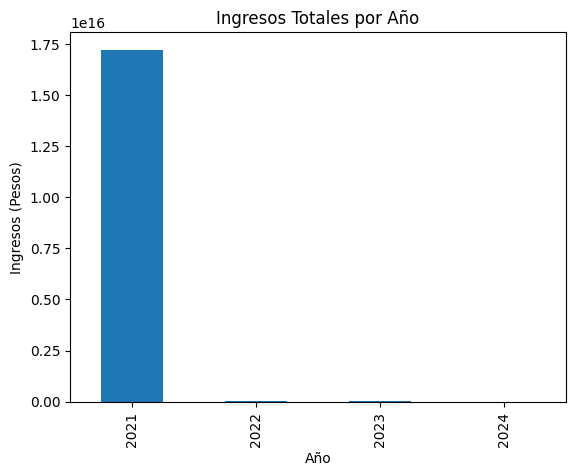

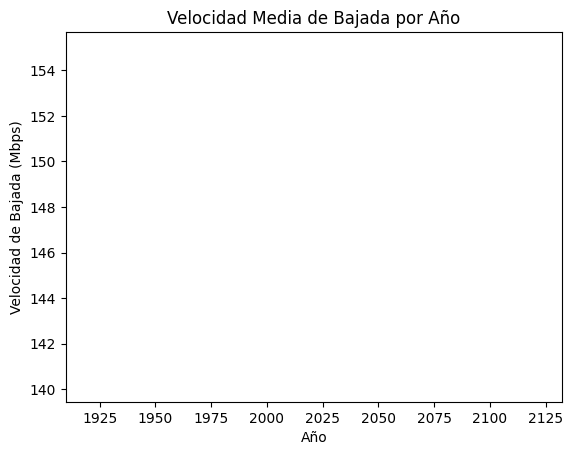

In [110]:
import matplotlib.pyplot as plt

# Ingresos Totales por Año
ingresos_por_año.plot(kind='bar')
plt.title("Ingresos Totales por Año")
plt.xlabel("Año")
plt.ylabel("Ingresos (Pesos)")
plt.show()

# Velocidad Media de Bajada por Año
velocidad_anual['VELOCIDAD BAJADA'].plot(kind='line')
plt.title("Velocidad Media de Bajada por Año")
plt.xlabel("Año")
plt.ylabel("Velocidad de Bajada (Mbps)")
plt.show()